In [1]:
import os
from typing import Optional

from notebook_utils import * 

# 1. Python in 10 minutes

This interface allows you to run Python code interactively and view the results immediately, along with any visualizations or text explanations. Each block of code or text you see is contained in what we call a "cell."

## Basic Operations

- **Running a Cell**: You can run the code or render the markdown in a cell by selecting it and pressing `Shift + Enter`, or by clicking the "Run" button in the toolbar.
- **Adding New Cells**: Add a new cell by clicking the "+" button in the toolbar.
- **Cell Types**: Cells can be code cells or markdown cells. Switch the type using the dropdown in the toolbar.


In [2]:
# Simple Python Example

# Printing a message
print("Hello, World!")

# Basic arithmetic
result = 7 * 6
print("7 multiplied by 6 is", result)

Hello, World!
7 multiplied by 6 is 42


In [3]:
# Using Variables

# Store a value in a variable
a = 10

# Use the variable in a calculation
b = a * 2

# Print the result
print("The result of a multiplied by 2 is", b)

The result of a multiplied by 2 is 20


In [4]:
# Basic Data Structures

# List: an ordered collection of items
fruits = ["apple", "banana", "cherry"]
print("Fruits List:", fruits)

# Dictionary: key-value pairs
prices = {"apple": 0.40, "banana": 0.50, "cherry": 0.30}
print("Fruit Prices:", prices)

Fruits List: ['apple', 'banana', 'cherry']
Fruit Prices: {'apple': 0.4, 'banana': 0.5, 'cherry': 0.3}


In [5]:
# Looping through a list
for fruit in fruits:
    print(fruit, "costs", prices[fruit], "each")

# Conditional: if statement
if "banana" in fruits:
    print("Yes, we have bananas!")

apple costs 0.4 each
banana costs 0.5 each
cherry costs 0.3 each
Yes, we have bananas!


### Introduction to Functions

Functions are a way to organize your code into blocks that can be called multiple times throughout your program. They allow you to write cleaner, more modular code and make your scripts easier to maintain and debug. Functions in Python are defined using the `def` keyword.


In [6]:
# Defining a Simple Function


def greet(name):
    """This function greets the person whose name is passed as a parameter"""
    return f"Hello, {name}! Welcome to our notebook."


# Calling the function
greeting = greet("Alice")
print(greeting)

Hello, Alice! Welcome to our notebook.


In [7]:
# Function with Parameters and Return Value


def calculate_area(length, width):
    """This function returns the area of a rectangle given its length and width."""
    area = length * width
    return area


# Using the function
rect_area = calculate_area(10, 5)
print("The area of the rectangle is:", rect_area)

The area of the rectangle is: 50


### Leveraging Jupyter-AI for Code Generation

Jupyter-AI is an advanced feature integrated into Jupyter Notebooks that helps users write code more efficiently. It utilizes AI technology to suggest code snippets, complete code blocks, and even generate complex code structures.

#### How to Use Jupyter-AI to Write Code

1. **Initiating Code Suggestions**: Simply start typing your code or a description of the function you need in a code cell. Jupyter-AI will automatically suggest completions.
2. **Accepting Suggestions**: When a code suggestion appears, you can press `Tab` to accept it, instantly filling in the suggestion.
3. **Chat Interface**: You can also interact with Jupyter-AI using the chat interface on the left.


In [ ]:
# try using the autocomplete functioanlity to write a function that adds two numbers


def add_numbers(a: int, b: int) -> int:
    """Try having jupyter AI autocomplete this function."""
    pass


# Assert statements to check the correctness of the function
assert add_numbers(1, 2) == 3, "Function add_numbers does not work correctly!"
print("Function add_numbers works correctly!")

In [ ]:
# We're not limited to simple functions. Here's a tricky function with a bug in it. Try pasting it into the chat bar on the left and asking the AI to fix it


def factorial(n: int) -> int:
    """This function has a bug in it. Can you find and fix it with AI?"""
    if n == 0:
        return 1
    else:
        result = 1
        for i in range(n):
            result *= i
        return result


# Assert statements to check the correctness of the function
assert factorial(0) == 1, "The factorial of 0 should be 1"
assert factorial(1) == 1, "The factorial of 1 should be 1"
assert factorial(5) == 120, "The factorial of 5 should be 120"

### Let's get started with the case study!


# High Level Architecture

The architecture of the system is as follows:

1. We chunk up the document into distinct “sections” and embed those sections
2. Then, we embed the user query and find the most similar part of the document.
3. We feed the original question along with context we found to the LLM and receive an answer


# 2. What exactly is an embedding?


In [7]:
from openai import OpenAI, NOT_GIVEN
import instructor
import plotly.graph_objects as go

#########################
### UTILITY FUNCTIONS ###
#########################

# instantiating the OpenAI client
client = instructor.patch(OpenAI(api_key=os.getenv("OPEN_AI_KEY")))
batch_size = 250
embedding_model = "text-embedding-3-large"


# wrapper function around openai to directly return embedding of text
def get_embedding(text: str | list[str], dimensions: int = NOT_GIVEN) -> list[float]:
    """Get the embedding of the input text."""
    if dimensions:
        assert dimensions <= 3072, "The maximum number of dimensions is 3072."

    response = client.embeddings.create(
        input=text, model=embedding_model, dimensions=dimensions
    )
    return response.data[0].embedding


def get_many_embeddings(texts: list[str]) -> list[list[float]]:
    """Get the embeddings of multiple texts."""
    batch_size = 250
    res = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i : i + batch_size]
        api_resp = client.embeddings.create(input=batch_texts, model=embedding_model)
        batch_res = [val.embedding for val in api_resp.data]
        res.extend(batch_res)

    return res


# simple utility function to add a vector to a 3D plot
def add_vector_to_graph(
    fig: go.Figure, vector: list[float], color: str = "red", name: Optional[str] = None
) -> go.Figure:
    # Ensure vector has exactly three components
    assert len(vector) == 3, "Vector must have exactly 3 components."

    # Origin point
    origin = [0, 0, 0]

    # Components of the vector
    x_component, y_component, z_component = vector

    # Adding the line part of the vector
    fig.add_trace(
        go.Scatter3d(
            x=[origin[0], x_component],
            y=[origin[1], y_component],
            z=[origin[2], z_component],
            mode="lines",
            line=dict(color=color, width=5),
            name=name,
        )
    )

    # Adding the cone at the tip of the vector
    fig.add_trace(
        go.Cone(
            x=[x_component],
            y=[y_component],
            z=[z_component],
            u=[x_component],
            v=[y_component],
            w=[z_component],
            sizemode="scaled",
            sizeref=0.1,
            showscale=False,
            colorscale=[[0, color], [1, color]],
            hoverinfo="none",
        )
    )
    return fig


def create_new_graph() -> go.Figure:
    """Create a 3D plotly figure with a simple layout."""
    fig = go.Figure()

    # make sure the plot isn't rotated
    fig.update_layout(
        scene=dict(
            camera=dict(
                eye=dict(x=1.5, y=1.5, z=0.5),  # Adjust the camera position
                up=dict(x=0, y=0, z=1),  # Sets the z-axis as "up"
                center=dict(x=0, y=0, z=0),  # Focuses the camera on the origin
            ),
            aspectmode="cube",
        )
    )

    # Add a dot at the origin
    fig.add_trace(
        go.Scatter3d(
            x=[0],
            y=[0],
            z=[0],
            mode="markers",
            marker=dict(size=6, color="black", symbol="circle"),
            name="Origin",
        )
    )

    return fig

#### Let's get started

For the purpose of the notebook we're going to use an OpenAI approach.

In [9]:
# let's try using the get_embedding function
result = get_embedding("Hello, World!")
print(result)

[0.0041542695835232735, -0.020751770585775375, -0.01990603841841221, 0.03354739025235176, 0.0029346137307584286, -0.01956148073077202, 0.0022180902305990458, 0.045011766254901886, 0.03433047607541084, 0.034769006073474884, -0.011840255931019783, 0.02700079418718815, 0.004694598726928234, -0.013218486681580544, 0.0020321074407547712, 0.03160533681511879, -0.04285044968128204, 0.01204385794699192, -0.0012558737071231008, -0.020892726257443428, 0.03721223026514053, -0.002409946173429489, -0.047110434621572495, 0.009819895029067993, 0.0006347888265736401, 0.020830079913139343, 0.008903684094548225, -0.0021045426838099957, -0.01970243640244007, -0.038809727877378464, 0.004060299135744572, 0.004573220387101173, 0.013116685673594475, 0.04670323058962822, 0.0506499819457531, 0.004949101712554693, 0.011339080519974232, 0.02253720536828041, 0.01425999030470848, 0.014839474111795425, 0.0168989896774292, 0.037525467574596405, -0.0023825382813811302, 0.03213783726096153, 0.010642134584486485, -0.00

That's a lot of numbers! OpenAI embedding support built in dimensionality reduction - let's try using that and visualizing the result


In [10]:
graph = create_new_graph()

text = "Atlanta"

# Get the embedding of the text
vector = get_embedding(text, dimensions=3)

# Add the vector to the plot
add_vector_to_graph(graph, vector, name=text)

# Show the plot
graph.show()

Let's try plotting a couple vectors at once to see if we can see any patterns

In [11]:
graph = create_new_graph()

text = "Atlanta"
atlanta_vector = get_embedding(text, dimensions=3)
add_vector_to_graph(graph, atlanta_vector, name=text, color="purple")

text = "Georgia, USA"
georgia_vector = get_embedding(text, dimensions=3)
add_vector_to_graph(graph, georgia_vector, name=text, color="blue")

text = "Skiing in japan"
ski_vector = get_embedding(text, dimensions=3)
add_vector_to_graph(graph, ski_vector, name=text, color="red")

# Show the plot
graph.show()

How we can quantify the similarity between two vectors? One common way is to use the cosine similarity. The cosine similarity between two vectors is the cosine of the angle between them. It ranges from -1 (opposite directions) to 1 (same direction), with 0 indicating orthogonality.

In [8]:
import numpy as np


def cosine_similarity(a: list[float], b: list[float]) -> float:
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))


# We can use the cosine similarity to compare the similarity between two vectors
similarity = cosine_similarity(atlanta_vector, georgia_vector)
print(f"The similarity between 'Atlanta' and 'Georgia, USA' is {similarity:.2f}")

similarity = cosine_similarity(atlanta_vector, ski_vector)
print(f"The similarity between 'Atlanta' and 'Skiing in Japan' is {similarity:.2f}")

NameError: name 'atlanta_vector' is not defined

### Advanced Challenges (Optional)

#### 1. Sentence Embeddings

How does adding words to a sentence affect the embedding vector? Try creating a for loop that adds a word to the text and plots the resulting embedding vector.

#### Hints:
1. Python strings have a split() method

```py
text = "This is a sentence."
words = text.split()
>>> words
['This', 'is', 'a', 'sentence.']
```


#### 2. Embedding Dimensionality
Let's see how the cosine similarity changes as we change the number of dimensions. 

How does increasing the number of dimensions affect how well the model can capture relationships between complex concepts?

In [56]:
# Try it out (implemented solutions can be found in the solutions.ipynb notebook)


# 3. Parsing Documents

Large language models are currently primarly optimized for working with text. As a result when dealing with documents like PDF's we need to first convert them into a text format before we can feed them into the model.

We maintain a popular open source library for doing this called [openparse](https://github.com/Filimoa/open-parse/). It is a simple and easy to use.


In [110]:
import openparse

#########################
### UTILITY FUNCTIONS ###
#########################


class VectorDatabase:
    """
    A simple in-memory database to store nodes along with their vectors and perform similarity search.
    """

    def __init__(self):
        self.nodes = []

    def add_node(self, node: openparse.Node) -> None:
        """Add a node along with its vector to the database."""
        assert node.embedding is not None, "Node must have an embedding."

        for existing_node in self.nodes:
            if existing_node.text == node.text:
                print(f"Node with id {node.node_id} already exists. Skipping")
                return

        self.nodes.append(node)

    def find_node(self, node_id: str):
        """Retrieve a node by its ID."""
        for node in self.nodes:
            if node.node_id == node_id:
                return node
        return None

    def remove_node(self, node_id: int) -> None:
        """Remove a node from the database."""
        for node in self.nodes:
            if node.node_id == node_id:
                self.nodes.remove(node)
                return
        raise ValueError(f"Node with id {node_id} not found.")

    def find_similar_node(
        self, input_vector: list[float], top_k: int = 3
    ) -> list[openparse.Node]:
        """Find the top_k nodes with the highest cosine similarity to the input_vector."""
        assert self.nodes, "Database is empty. Please add nodes first."
        assert top_k <= len(
            self.nodes
        ), "top_k should be less than or equal to the number of nodes."

        similarities = []
        for node in self.nodes:
            similarity = cosine_similarity(input_vector, node.embedding)
            similarities.append((node, similarity))

        similarities.sort(key=lambda x: x[1], reverse=True)

        return [node for node, _ in similarities[:top_k]]

    @property
    def num_nodes(self) -> int:
        """Return the number of nodes in the database."""
        return len(self.nodes)

    def delete_all_nodes(self) -> None:
        """Delete all nodes from the database."""
        self.nodes = []


# try:
#     assert db
# except NameError:
#     db = VectorDatabase()

db = VectorDatabase()

In [9]:
import openparse

doc_path = "./docs/dallas-site-assessment.pdf"
pdf = openparse.Pdf(doc_path)
parser = openparse.DocumentParser()
parsed_doc = parser.parse(doc_path)

Nodes are parsed as markdown - bold text is kept. This helps LLM's understand the structure of the document. Let's try looking at the first couple nodes.

In [10]:
for node in parsed_doc.nodes[4:6]:
    display(node)
    print("====================================")

**ESA CERTIFICATION**<br><br>Mach 8 Consulting (M8) is pleased to submit this Phase I Environmental Site Assessment report for 
Oaks at Hampton Apartments, located at 2514 Perryton Drive, Dallas, Texas (the Site). The primary 
purpose of this assessment was to identify Recognized Environmental Conditions in connection with 
the Site. <br><br>In conducting this assessment, M8 followed the E1527-13 American Society for Testing and Materials 
(ASTM) document entitled "Standard Practices for Environmental Site Assessments: Phase I 
Environmental Site Assessment Process" for commercial real estate. Recognized Environmental 
Conditions are defined under ASTM 1527-13 as the presence or likely presence of hazardous substances 
or petroleum products on a property under conditions that indicate an existing release, a past release, or 
material threat of a release into structures on the property or into the ground, groundwater, or surface 
water of the property. <br><br>We have also performed this study in general accordance with HUD Multifamily Accelerated 
Processing (MAP) Guide, originally published May 17, 2000; as revised on March 7, 2002, August 22, 
2011, and January 29, 2016, including the completion of a Vapor Encroachment Screening. The Vapor 
Encroachment Screening was performed in accordance with the ASTM E 2600-10 Standard entitled 
“Standard Guide for Vapor Encroachment Screening a Property Involved in Real Estate Transactions”, 
as published in June of 2010. 

To the best of my knowledge, this Phase I Environmental Site Assessment report is true and accurate. 
I declare that, to the best of my professional knowledge and belief, we meet the definition of 
Environmental Professionals as defined in 40 CFR 312. We have the specific qualifications based on 
education, training, and experience to assess a Site of the nature, history, and setting of the Site. We 
have developed and performed the all appropriate inquiries in general conformance with the standards 
and practices set forth in 40 CFR Part 312 and attest to the completeness and accuracy of the information 
contained in this report. <br><br>On behalf of M8, we appreciate the opportunity to work with Greystone Funding Corporation on this 
project. If you have any questions concerning the findings and conclusions contained in this report, 
please contact undersigned at 207-351-8926. <br><br>Mach 8 Consulting 

In [11]:
# let's embed all the nodes and add to the database
raw_node_texts = [node.text for node in parsed_doc.nodes]
embeddings = get_many_embeddings(raw_node_texts)

for node, embedding in zip(parsed_doc.nodes, embeddings):
    node.embedding = embedding
    db.add_node(node)

# 4. Querying

In [25]:
#########################
### UTILITY FUNCTIONS ###
#########################

from IPython.display import Markdown


def get_completion(prompt: str) -> Markdown:
    """
    OpenAI returns a complex object, this is a simple wrapper function to directly return the completion text.
    """
    completion = client.chat.completions.create(
        model="gpt-4-turbo",
        messages=[
            {
                "role": "user",
                "content": prompt,
            },
        ],
    )
    return Markdown(completion.choices[0].message.content)


def display_similar_nodes(
    similar_nodes: list[openparse.Node], query_vector: list[float], pdf: openparse.Pdf
) -> None:
    page_nums = set()
    annotations = []
    for node in similar_nodes:
        sim = cosine_similarity(query_vector, node.embedding)
        page_nums.add(node.start_page)
        page_nums.add(node.end_page)
        annotations.append(round(sim, 3))

    pdf.display_with_bboxes(similar_nodes, page_nums=page_nums, annotations=annotations)

In [22]:
# let's try asking one of our original questions

question = "Was there any asbestos found in the building?"

# Get the embedding of the text
query_vector = get_embedding(question)

# find the most similar node
similar_nodes = db.find_similar_node(query_vector, top_k=5)

for node in similar_nodes:
    sim = cosine_similarity(query_vector, node.embedding)
    print(
        f"Found similar node on page {node.start_page} with a similarity of {sim:.2f}"
    )

Found similar node on page 16 with a similarity of 0.58
Found similar node on page 16 with a similarity of 0.56
Found similar node on page 147 with a similarity of 0.45
Found similar node on page 9 with a similarity of 0.44
Found similar node on page 145 with a similarity of 0.44


You can give GPT knowledge about a topic by inserting it into an input message
To help give the model knowledge of curling at the 2022 Winter Olympics, we can copy and paste the top half of a relevant Wikipedia article into our message:

In [15]:
# create a single string of all the similar nodes
context = "\n\n".join([node.text for node in similar_nodes])

print(context)

Visual inspections of accessible building materials were conducted by M8 in an effort to identify 
materials suspected of containing asbestos. The visual inspection did not include inaccessible spaces 
within the Site buildings. Determination of whether buildings contain asbestos can only be ascertained 
by performing an asbestos survey. No asbestos sampling was conducted as part of this assessment. <br><br>Based on the original date of construction of Site buildings (2001), it is unlikely that significant amounts 
of ACMs were utilized during construction. M8 did not identify any suspect ACMs during the 
assessment. <br><br> ACMs are not considered to be a concern with respect to this investigation. <br><br>**5.9 Lead-based Paint**<br><br>Lead-based paint was historically utilized prior to 1978. Lead exposure can occur through contact with 
paint dust or paint chips which contain lead. Potential health effects and symptoms associated with 
childhood lead exposure include neurological

In [17]:
prompt_template = """
Using the document provided, answer the following question:

question: {question}

context: {context}
"""

prompt = prompt_template.format(question=question, context=context)

completion = get_completion(prompt)


print("Original Question:", question)
completion

Original Question: Was there any asbestos found in the building?


No asbestos was found in the building. According to the document, there was a visual inspection conducted to identify materials suspected of containing asbestos, but no asbestos sampling was performed as part of this assessment. The document notes that based on the construction date of the buildings (2001), it is unlikely that significant amounts of asbestos-containing materials (ACMs) were utilized, and no suspect ACMs were identified during the assessment. Therefore, asbestos is not considered a concern with respect to this investigation.

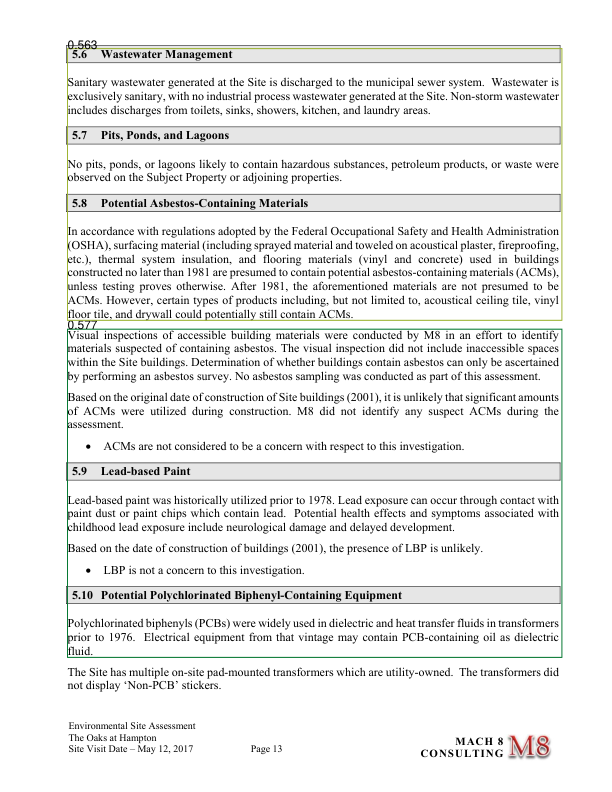

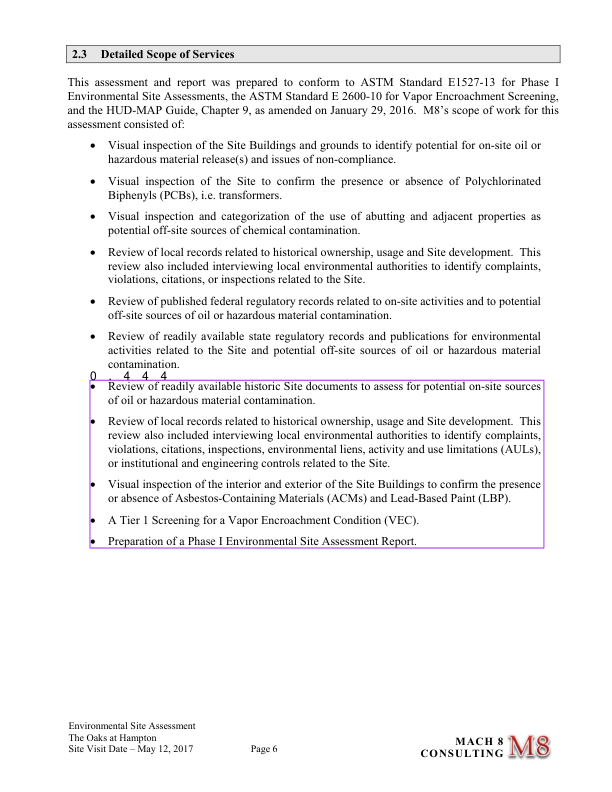

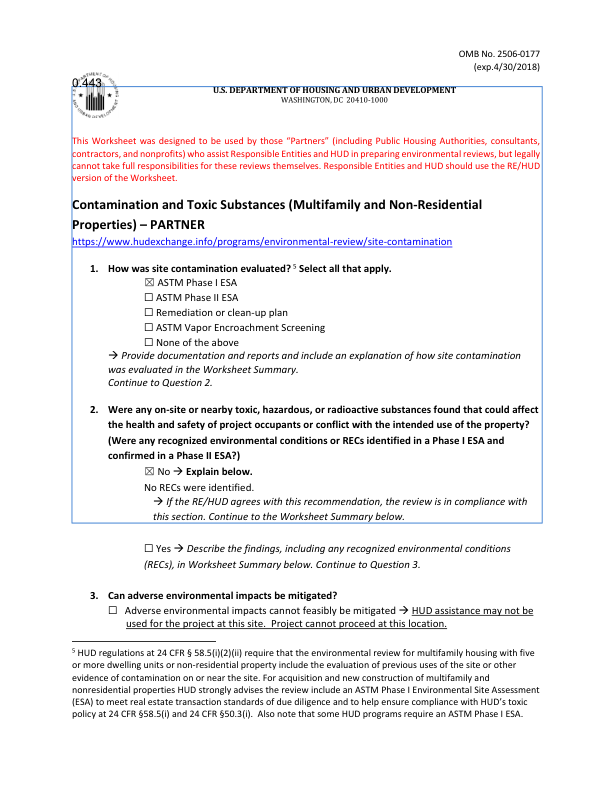

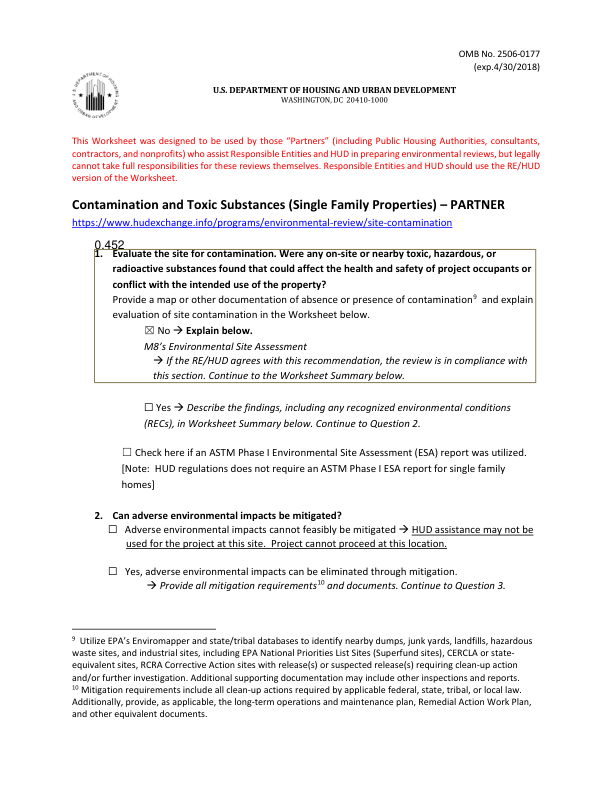

In [26]:
display_similar_nodes(similar_nodes, query_vector, pdf)

### Advanced Challenges (Optional)

#### 1. Modifying Embedding Dimensions

Try modifying the number of dimensions in the embedding vector and seeing how it affects the retreival process.

## 5: Structured Output

In [27]:
from pydantic import BaseModel


class ContainsAsbestos(BaseModel):
    contains_asbestos: bool


response = client.chat.completions.create(
    model="gpt-4-turbo",
    messages=[
        {
            "role": "user",
            "content": prompt,
        },
    ],
    response_model=ContainsAsbestos,
)

print(response.dict())

{'contains_asbestos': False}
